In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def create_simple_dataset(n_samples=1000):
    # Create a sine wave with some noise
    x = np.linspace(0, 4*np.pi, n_samples)
    y = np.sin(x) + 0.1 * np.random.normal(0, 1, n_samples)

    # Normalize to [0, 1] range for easier training
    y = (y + 1.5) / 3.0  # Rough normalization
    y = np.clip(y, 0, 1)  # Ensure values are in [0,1]

    return y.reshape(-1, 1)  # Make it 2D for neural networks

# Create our simple dataset - think of each point as a "pixel intensity"
real_data = create_simple_dataset(1000)
print(f"Real data shape: {real_data.shape}")
print(f"Real data range: [{real_data.min():.3f}, {real_data.max():.3f}]")

Real data shape: (1000, 1)
Real data range: [0.097, 0.912]


#### Training process of GANs

In [3]:
print("\n=== BUILDING A SIMPLE GAN ===")

class SimpleGAN:
    def __init__(self, data_dim=1, noise_dim=10):
        self.data_dim = data_dim      # Size of real data (1D in our case)
        self.noise_dim = noise_dim    # Size of random noise input

        # Build the two competing networks
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Compile discriminator
        self.discriminator.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # For training generator, we freeze discriminator
        self.discriminator.trainable = False

        # Combined model for training generator
        noise_input = keras.Input(shape=(self.noise_dim,))
        fake_data = self.generator(noise_input)
        validity = self.discriminator(fake_data)

        self.combined = keras.Model(noise_input, validity)
        self.combined.compile(
            optimizer='adam',
            loss='binary_crossentropy'
        )

    def build_generator(self):
        model = keras.Sequential([
            layers.Dense(16, activation='relu', input_shape=(self.noise_dim,)),
            layers.Dense(8, activation='relu'),
            layers.Dense(self.data_dim, activation='sigmoid')  # Output in [0,1]
        ], name='Generator')

        print("Generator Architecture:")
        model.summary()
        return model

    def build_discriminator(self):
        model = keras.Sequential([
            layers.Dense(8, activation='relu', input_shape=(self.data_dim,)),
            layers.Dense(4, activation='relu'),
            layers.Dense(1, activation='sigmoid')  # Output: probability it's real
        ], name='Discriminator')

        print("Discriminator Architecture:")
        model.summary()
        return model

    def train_step(self, real_batch):
        """
        One training step: The competition between generator and discriminator
        """
        batch_size = len(real_batch)

        # ============================================
        # STEP 1: Train Discriminator
        # ============================================

        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        fake_batch = self.generator.predict(noise, verbose=0)

        # Create labels: 1 = real, 0 = fake
        real_labels = np.ones((batch_size, 1))  # All 1s for real data
        fake_labels = np.zeros((batch_size, 1))  # All 0s for fake data

        # Train discriminator on real data (should output 1)
        d_loss_real = self.discriminator.train_on_batch(real_batch, real_labels)

        # Train discriminator on fake data (should output 0)
        d_loss_fake = self.discriminator.train_on_batch(fake_batch, fake_labels)

        # Average discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ============================================
        # STEP 2: Train Generator
        # ============================================

        # Generate new noise
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

        # Train generator to fool discriminator
        # We want discriminator to think these are real (label = 1)
        misleading_labels = np.ones((batch_size, 1))
        g_loss = self.combined.train_on_batch(noise, misleading_labels)

        return d_loss, g_loss

    def generate_samples(self, n_samples=100):
        """Generate fake samples using trained generator"""
        noise = np.random.normal(0, 1, (n_samples, self.noise_dim))
        return self.generator.predict(noise, verbose=0)

# Create and train the GAN
print("Creating GAN...")
gan = SimpleGAN(data_dim=1, noise_dim=10)

print("\n=== TRAINING GAN (The Competition!) ===")
print("Watch how Generator and Discriminator compete:")


=== BUILDING A SIMPLE GAN ===
Creating GAN...
Generator Architecture:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator Architecture:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)


=== TRAINING GAN (The Competition!) ===
Watch how Generator and Discriminator compete:


In [4]:
# Training loop
epochs = 100
batch_size = 32
d_losses, g_losses = [], []

for epoch in range(epochs):
    # Get random batch of real data
    idx = np.random.randint(0, len(real_data), batch_size)
    real_batch = real_data[idx]

    # Train one step
    d_loss, g_loss = gan.train_step(real_batch)

    d_losses.append(d_loss[0])  # Loss value
    g_losses.append(g_loss)

    # Print progress every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d}: D_loss={d_loss[0]:.3f}, D_acc={d_loss[1]:.3f}, G_loss={g_loss:.3f}")

print("GAN training completed!")

# Generate samples with trained GAN
gan_samples = gan.generate_samples(500)

Epoch   0: D_loss=0.653, D_acc=0.750, G_loss=0.623
Epoch  20: D_loss=0.688, D_acc=0.506, G_loss=0.618
Epoch  40: D_loss=0.693, D_acc=0.503, G_loss=0.611
Epoch  60: D_loss=0.697, D_acc=0.502, G_loss=0.604
Epoch  80: D_loss=0.700, D_acc=0.502, G_loss=0.599
GAN training completed!


#### simple diffusion model implementation

In [5]:
print("\n=== BUILDING A SIMPLE DIFFUSION MODEL ===")

class SimpleDiffusion:
    def __init__(self, data_dim=1, max_timesteps=50):
        self.data_dim = data_dim
        self.max_timesteps = max_timesteps

        # Create noise schedule (how much noise to add at each step)
        self.betas = np.linspace(0.0001, 0.02, max_timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)  # Cumulative product

        # Build denoising network
        self.denoiser = self.build_denoiser()
        self.denoiser.compile(optimizer='adam', loss='mse')

    def build_denoiser(self):

        # Input for noisy data
        data_input = keras.Input(shape=(self.data_dim,), name='noisy_data')

        # Input for timestep (what level of noise we're dealing with)
        time_input = keras.Input(shape=(1,), name='timestep')

        # Simple embedding for timestep
        time_embed = layers.Dense(8, activation='relu')(time_input)

        # Concatenate data and time information
        combined = layers.Concatenate()([data_input, time_embed])

        # Network to predict noise
        x = layers.Dense(16, activation='relu')(combined)
        x = layers.Dense(8, activation='relu')(x)
        predicted_noise = layers.Dense(self.data_dim, activation='linear')(x)

        model = keras.Model([data_input, time_input], predicted_noise, name='Denoiser')
        print("Denoiser Architecture:")
        model.summary()
        return model

    def add_noise(self, x, t):

        # Get noise level for timestep t
        alpha_bar = self.alpha_bars[t]

        # Generate random noise
        noise = np.random.normal(0, 1, x.shape)

        # Mix original data with noise according to schedule
        # Formula: noisy = sqrt(alpha_bar) * original + sqrt(1-alpha_bar) * noise
        noisy_x = np.sqrt(alpha_bar) * x + np.sqrt(1 - alpha_bar) * noise

        return noisy_x, noise

    def prepare_training_data(self, real_data, n_samples=1000):

        training_noisy = []
        training_noise = []
        training_timesteps = []

        for _ in range(n_samples):
            # Pick random sample from real data
            idx = np.random.randint(0, len(real_data))
            clean_sample = real_data[idx:idx+1]

            # Pick random timestep
            t = np.random.randint(0, self.max_timesteps)

            # Add noise according to timestep
            noisy_sample, noise = self.add_noise(clean_sample, t)

            training_noisy.append(noisy_sample[0])
            training_noise.append(noise[0])
            training_timesteps.append([t])

        return (np.array(training_noisy),
                np.array(training_timesteps)), np.array(training_noise)

    def train(self, real_data, epochs=50):
        """Train the denoising network"""
        print("Training Diffusion Model...")
        print("Learning to remove noise step by step...")

        for epoch in range(epochs):
            # Prepare training batch
            (noisy_data, timesteps), target_noise = self.prepare_training_data(real_data, 100)

            # Train denoiser to predict noise
            loss = self.denoiser.train_on_batch([noisy_data, timesteps], target_noise)

            if epoch % 10 == 0:
                print(f"Epoch {epoch:2d}: Loss = {loss:.4f}")

        print("Diffusion model training completed!")

    def generate_sample(self):

        # Start with pure random noise
        x = np.random.normal(0, 1, (1, self.data_dim))

        # Gradually remove noise (reverse process)
        for t in range(self.max_timesteps-1, -1, -1):
            timestep = np.array([[t]])

            # Predict noise at this timestep
            predicted_noise = self.denoiser.predict([x, timestep], verbose=0)

            # Remove predicted noise
            alpha = self.alphas[t]
            alpha_bar = self.alpha_bars[t]

            # Denoising formula
            x = (1/np.sqrt(alpha)) * (x - (self.betas[t]/np.sqrt(1-alpha_bar)) * predicted_noise)

            # Add small amount of noise (except at last step)
            if t > 0:
                noise = np.random.normal(0, 1, x.shape)
                x = x + np.sqrt(self.betas[t]) * noise

        return x

    def generate_samples(self, n_samples=100):
        """Generate multiple samples"""
        samples = []
        print(f"Generating {n_samples} samples with diffusion model...")
        for i in range(n_samples):
            if i % 20 == 0:
                print(f"Generated {i}/{n_samples} samples...")
            sample = self.generate_sample()
            samples.append(sample[0])
        return np.array(samples)

# Create and train diffusion model
print("Creating Diffusion Model...")
diffusion = SimpleDiffusion(data_dim=1, max_timesteps=20)  # Fewer steps for speed

# Train the diffusion model
diffusion.train(real_data, epochs=50)

# Generate samples with trained diffusion model
diffusion_samples = diffusion.generate_samples(500)


=== BUILDING A SIMPLE DIFFUSION MODEL ===
Creating Diffusion Model...
Denoiser Architecture:


Model: "Denoiser"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timestep            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noisy_data          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │         16 │ timestep[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9)         │          0 │ noisy_data[0][0], │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        136 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │          9 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

Training Diffusion Model...
Learning to remove noise step by step...
Epoch  0: Loss = 2.1073
Epoch 10: Loss = 1.6196
Epoch 20: Loss = 1.3948
Epoch 30: Loss = 1.2694
Epoch 40: Loss = 1.2116
Diffusion model training completed!
Generating 500 samples with diffusion model...
Generated 0/500 samples...
Generated 20/500 samples...
Generated 40/500 samples...
Generated 60/500 samples...
Generated 80/500 samples...
Generated 100/500 samples...
Generated 120/500 samples...
Generated 140/500 samples...
Generated 160/500 samples...
Generated 180/500 samples...
Generated 200/500 samples...
Generated 220/500 samples...
Generated 240/500 samples...
Generated 260/500 samples...
Generated 280/500 samples...
Generated 300/500 samples...
Generated 320/500 samples...
Generated 340/500 samples...
Generated 360/500 samples...
Generated 380/500 samples...
Generated 400/500 samples...
Generated 420/500 samples...
Generated 440/500 samples...
Generated 460/500 samples...
Generated 480/500 samples...


#### Compare result between GANs and Diffusion model

In [6]:
def analyze_samples(real, gan_generated, diffusion_generated):
    """Compare the quality of generated samples"""

    print("Sample Statistics:")
    print(f"Real data      - Mean: {real.mean():.3f}, Std: {real.std():.3f}")
    print(f"GAN samples    - Mean: {gan_generated.mean():.3f}, Std: {gan_generated.std():.3f}")
    print(f"Diffusion      - Mean: {diffusion_generated.mean():.3f}, Std: {diffusion_generated.std():.3f}")

    # Show some actual values
    print(f"\nFirst 5 Real samples:      {real[:5].flatten()}")
    print(f"First 5 GAN samples:       {gan_generated[:5].flatten()}")
    print(f"First 5 Diffusion samples: {diffusion_generated[:5].flatten()}")

analyze_samples(real_data, gan_samples, diffusion_samples)

Sample Statistics:
Real data      - Mean: 0.501, Std: 0.236
GAN samples    - Mean: 0.708, Std: 0.109
Diffusion      - Mean: -0.110, Std: 1.233

First 5 Real samples:      [0.51655714 0.49958406 0.5299747  0.56334363 0.50895974]
First 5 GAN samples:       [0.64456475 0.7483598  0.75240916 0.8368357  0.77194214]
First 5 Diffusion samples: [ 0.58317131 -0.03745498 -1.73043639  1.51673513  0.66191556]



Visualization saved as 'gan_vs_diffusion_comparison.png'


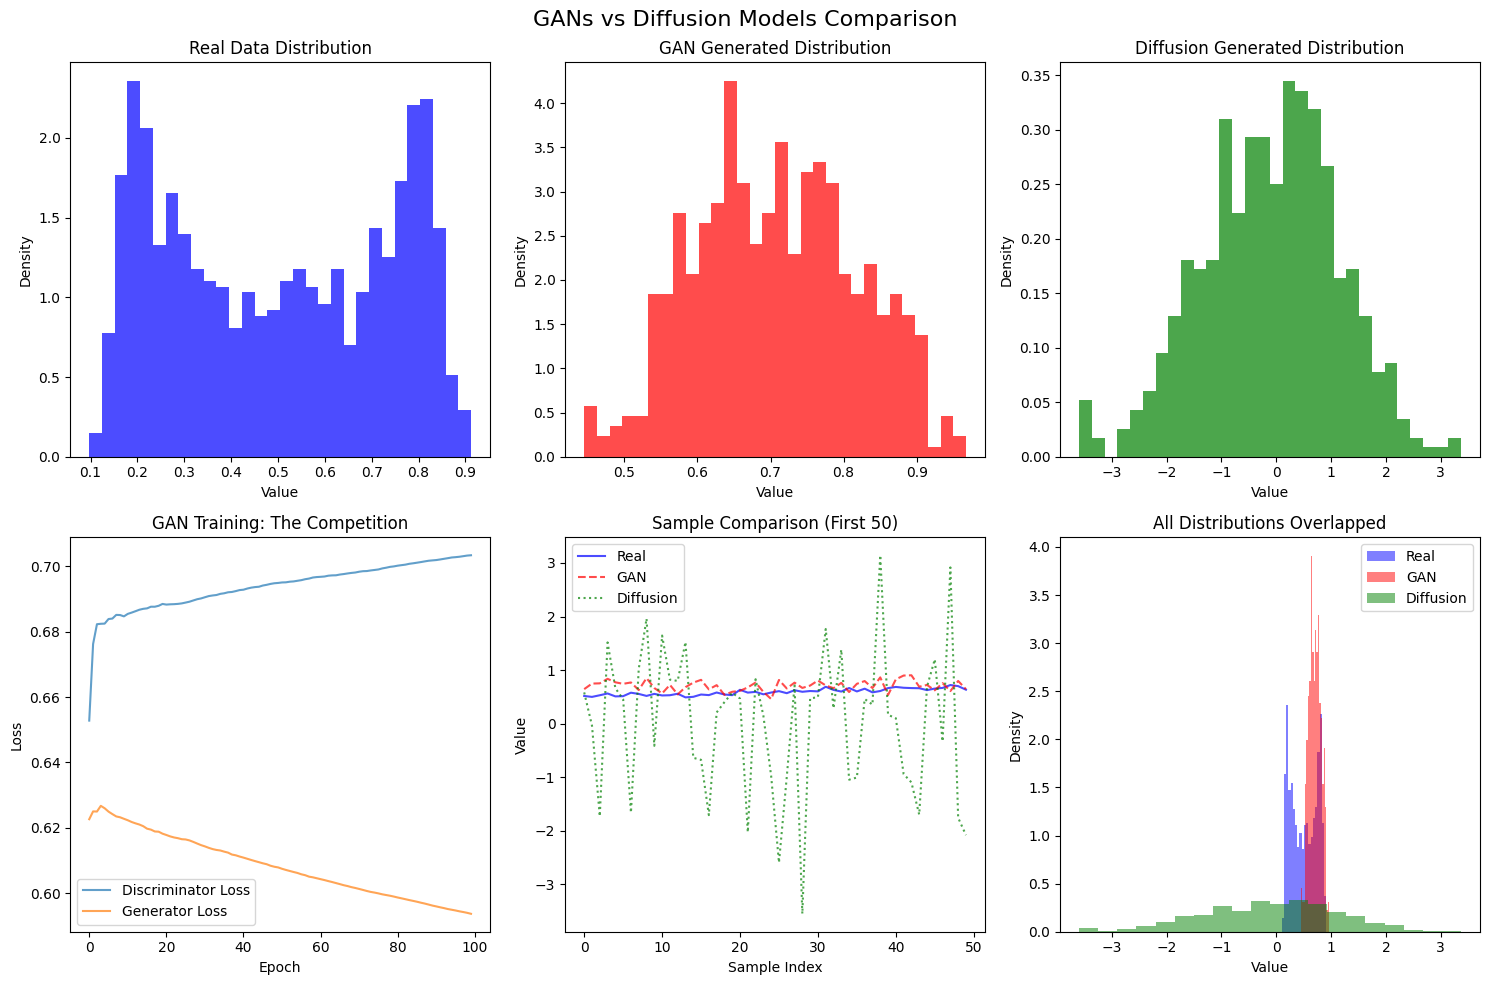


=== DEMONSTRATING KEY DIFFERENCES ===
1. GENERATION SPEED TEST:
Generating 10 samples with diffusion model...
Generated 0/10 samples...
GAN: Generated 100 samples in 0.29 seconds (0.0029s per sample)
Diffusion: Generated 10 samples in 15.33 seconds (1.5332s per sample)
Speed ratio: GAN is ~528.3x faster


In [7]:
def create_comparison_plot():
    """Create visualization comparing all approaches"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('GANs vs Diffusion Models Comparison', fontsize=16)

    # Plot 1: Real data distribution
    axes[0,0].hist(real_data.flatten(), bins=30, alpha=0.7, color='blue', density=True)
    axes[0,0].set_title('Real Data Distribution')
    axes[0,0].set_xlabel('Value')
    axes[0,0].set_ylabel('Density')

    # Plot 2: GAN generated distribution
    axes[0,1].hist(gan_samples.flatten(), bins=30, alpha=0.7, color='red', density=True)
    axes[0,1].set_title('GAN Generated Distribution')
    axes[0,1].set_xlabel('Value')
    axes[0,1].set_ylabel('Density')

    # Plot 3: Diffusion generated distribution
    axes[0,2].hist(diffusion_samples.flatten(), bins=30, alpha=0.7, color='green', density=True)
    axes[0,2].set_title('Diffusion Generated Distribution')
    axes[0,2].set_xlabel('Value')
    axes[0,2].set_ylabel('Density')

    # Plot 4: GAN training progress
    axes[1,0].plot(d_losses, label='Discriminator Loss', alpha=0.7)
    axes[1,0].plot(g_losses, label='Generator Loss', alpha=0.7)
    axes[1,0].set_title('GAN Training: The Competition')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Loss')
    axes[1,0].legend()

    # Plot 5: Sample comparison
    x_axis = range(50)  # First 50 samples
    axes[1,1].plot(x_axis, real_data[:50].flatten(), 'b-', label='Real', alpha=0.7)
    axes[1,1].plot(x_axis, gan_samples[:50].flatten(), 'r--', label='GAN', alpha=0.7)
    axes[1,1].plot(x_axis, diffusion_samples[:50].flatten(), 'g:', label='Diffusion', alpha=0.7)
    axes[1,1].set_title('Sample Comparison (First 50)')
    axes[1,1].set_xlabel('Sample Index')
    axes[1,1].set_ylabel('Value')
    axes[1,1].legend()

    # Plot 6: All distributions overlapped
    axes[1,2].hist(real_data.flatten(), bins=20, alpha=0.5, color='blue',
                   density=True, label='Real')
    axes[1,2].hist(gan_samples.flatten(), bins=20, alpha=0.5, color='red',
                   density=True, label='GAN')
    axes[1,2].hist(diffusion_samples.flatten(), bins=20, alpha=0.5, color='green',
                   density=True, label='Diffusion')
    axes[1,2].set_title('All Distributions Overlapped')
    axes[1,2].set_xlabel('Value')
    axes[1,2].set_ylabel('Density')
    axes[1,2].legend()

    plt.tight_layout()
    return fig

# Create visualization
try:
    fig = create_comparison_plot()
    plt.savefig('gan_vs_diffusion_comparison.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved as 'gan_vs_diffusion_comparison.png'")
    plt.show()
except:
    print("Matplotlib not available for display, but code ran successfully!")

# ====================================================================
# PART 6: DEMONSTRATE KEY DIFFERENCES
# ====================================================================

print("\n=== DEMONSTRATING KEY DIFFERENCES ===")

print("1. GENERATION SPEED TEST:")
import time

# Time GAN generation
start_time = time.time()
gan_fast = gan.generate_samples(100)
gan_time = time.time() - start_time

# Time Diffusion generation
start_time = time.time()
diffusion_fast = diffusion.generate_samples(10)  # Fewer samples due to speed
diffusion_time = time.time() - start_time
diffusion_time_per_sample = diffusion_time / 10

print(f"GAN: Generated 100 samples in {gan_time:.2f} seconds ({gan_time/100:.4f}s per sample)")
print(f"Diffusion: Generated 10 samples in {diffusion_time:.2f} seconds ({diffusion_time_per_sample:.4f}s per sample)")
print(f"Speed ratio: GAN is ~{diffusion_time_per_sample/(gan_time/100):.1f}x faster")